# Machine Learning Complements Project
# IMDb Movies Recommender System and Genre Prediction
### G5 - Veronija Kodovska, Maria Fain and Fabijan Bošnjak

In [44]:
import pandas as pd
import numpy as np
import json
import nltk
from datetime import datetime, timedelta
from pathlib import Path
#nltk.download('stopwords')
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from recommenders.datasets.python_splitters import python_stratified_split
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [2]:
movies = pd.read_csv("movies_metadata.csv", sep = ',', low_memory=False)

In [3]:
ratings = pd.read_csv("ratings.csv")
#for a more fast run you can load the smaller dataset right away
#ratings_small = pd.read_csv("ratings_smaller.csv")

In [4]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

We will be using two datasets - movies and ratings, one with information about movies from IMDb which will be used for genre prediction and the other, containing the same movies with ratings from users which will be used for building a recommender system which we will merge after preprocessing the data.

In [5]:
#delete unnecessary columns
movies = movies.drop(['belongs_to_collection', 'adult', 'budget', 'original_language', 'popularity', 
                'poster_path', 'production_companies', 'production_countries', 'revenue', 'runtime', 
                'spoken_languages', 'status', 'tagline', 'video', 'vote_average', 'vote_count', 'homepage',
                'imdb_id', 'release_date', 'original_title'], axis=1)
movies = movies.rename(columns={'id': 'movieId'})
movies

,genres,movieId,overview,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,Rising and falling between a man and woman.,Subdue
45462,"[{'id': 18, 'name': 'Drama'}]",111109,An artist struggles to finish his work while a...,Century of Birthing
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,"When one of her hits goes wrong, a professiona...",Betrayal
45464,[],227506,"In a small town live two brothers, one a minis...",Satan Triumphant


The features we will be using from dataset 1 are:
 - genres &ndash; an array with the id and name of genres which we will transform
 - movieId &ndash; movie id
 - overview &ndash; a text description of the movie
 - title &ndash; title of the movie

In [6]:
movies.describe()

,genres,movieId,overview,title
count,45466,45466,44512,45460
unique,4069,45436,44307,42277
top,"[{'id': 18, 'name': 'Drama'}]",141971,No overview found.,Cinderella
freq,5000,3,133,11


In [7]:
print(ratings.columns)
ratings

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


The features we will be using from dataset 2 are:
 - userId &ndash; id of the user who gave the review
 - movieId &ndash; id of the movie the user rated
 - rating &ndash; a rating on a 5-star scale with half-star increments (0.5 - 5 stars)
 - timestamp

In [28]:
ratings.describe()

,userId,movieId,rating
count,2.484810e+07,2.484810e+07,2.484810e+07
mean,1.350036e+05,1.621173e+04,3.528737e+00
std,7.817512e+04,3.135802e+04,1.060048e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,6.712600e+04,1.088000e+03,3.000000e+00
50%,1.351340e+05,2.670000e+03,3.500000e+00
75%,2.026420e+05,6.711000e+03,4.000000e+00
max,2.708960e+05,1.762750e+05,5.000000e+00


Since the ratings dataset is quite large and was giving us trouble with memory and certain functions, we decided to decrease it's size. Firstly, we will transform the timestamps to ISO format and then sort the dataset chronologically. Then we will take the first 2000000 rows and use this dataset going forward. We also exported the smaller dataset to a .csv file for easier uploads and faster testing.

In [8]:
ratings['timestamp'] = ratings.apply(
    lambda x: datetime.strftime(datetime(1970, 1, 1, 0, 0, 0) + timedelta(seconds=x['timestamp'].item()), "%Y-%m-%d %H:%M:%S"), 
    axis=1)
ratings = ratings.sort_values('timestamp').reset_index(drop=True)
ratings

,userId,movieId,rating,timestamp
0,38150,1176,4.0,1995-01-09 11:46:44
1,44717,1079,3.0,1995-01-09 11:46:49
2,44717,47,5.0,1995-01-09 11:46:49
3,44717,21,3.0,1995-01-09 11:46:49
4,190860,21,5.0,1996-01-29 00:00:00
...,...,...,...,...
26024284,85434,3210,2.0,2017-08-04 06:38:59
26024285,85434,82169,3.0,2017-08-04 06:39:06
26024286,85434,1013,4.0,2017-08-04 06:41:23
26024287,199634,60040,3.0,2017-08-04 06:53:43


In [14]:
ratings_small = ratings.iloc[:2000000,:]
filepath = Path('ratings_smaller.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  
ratings_small.to_csv(index=False, path_or_buf=filepath)

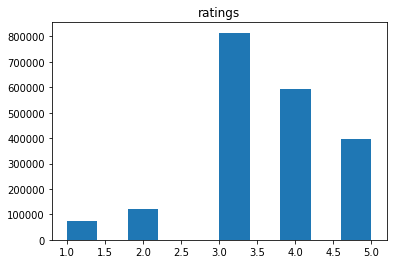

In [15]:
plt.hist(ratings_small['rating'])
plt.title('ratings')
plt.show()

In [17]:
#checking for empty values
print(movies.isna().sum())
print(ratings_small.isna().sum())

genres        0
movieId       0
overview    954
title         6
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [18]:
#remove movies without titles
movies.drop(movies[movies['title'].isna()].index, inplace=True)
#remove movies without overview
movies.drop(movies[movies['overview'].isna()].index, inplace=True)

In [19]:
#checking for empty values
print(movies.isna().sum())
print(ratings_small.isna().sum())

genres      0
movieId     0
overview    0
title       0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [20]:
#remove movies without specified genres
movies.drop(movies[movies['genres'] == '[]'].index, inplace=True)
movies

,genres,movieId,overview,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...,...
45459,"[{'id': 878, 'name': 'Science Fiction'}]",222848,It's the year 3000 AD. The world's most danger...,Caged Heat 3000
45460,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",30840,"Yet another version of the classic epic, with ...",Robin Hood
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,Rising and falling between a man and woman.,Subdue
45462,"[{'id': 18, 'name': 'Drama'}]",111109,An artist struggles to finish his work while a...,Century of Birthing


In [21]:
#convert genres to a list without their ids
genres = []
for i in movies['genres']:
    gList = str.split(i, sep='\'name\': \'')
    for j in range(1, len(gList)):
        gList[j] = gList[j].split('\'')[0]
    gList.pop(0)
    genres.append(gList)
    
movies['genres'] = genres
movies

,genres,movieId,overview,title
0,"[Animation, Comedy, Family]",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[Adventure, Fantasy, Family]",8844,When siblings Judy and Peter discover an encha...,Jumanji
2,"[Romance, Comedy]",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[Comedy, Drama, Romance]",31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,[Comedy],11862,Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...,...
45459,[Science Fiction],222848,It's the year 3000 AD. The world's most danger...,Caged Heat 3000
45460,"[Drama, Action, Romance]",30840,"Yet another version of the classic epic, with ...",Robin Hood
45461,"[Drama, Family]",439050,Rising and falling between a man and woman.,Subdue
45462,[Drama],111109,An artist struggles to finish his work while a...,Century of Birthing


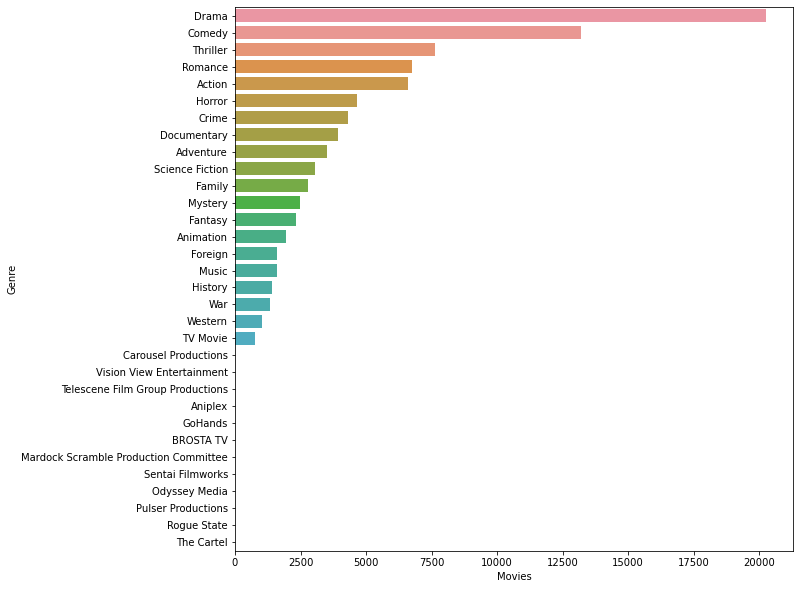

In [10]:
#barplot unique genres
allGenres = sum(genres, [])
allGenres = nltk.FreqDist(allGenres) 

genresDf = pd.DataFrame({'Genre': list(allGenres.keys()), 
                         'Movies': list(allGenres.values())})

plt.figure(figsize=(10,10)) 
sns.barplot(data=genresDf, x="Movies", y="Genre", order=genresDf.sort_values('Movies', ascending=False).Genre) 
plt.show()

It is clear from the plot that there are some genres that are represented in very little numbers and when inspected more closely, don't seem to resemble actual genre names but production company names. We will drop them from the dataset.

In [22]:
nonGenres = ['Carousel Productions', 'Vision View Entertainment', 'Telescene Film Group Productions', 
            'Aniplex', 'GoHands', 'BROSTA TV', 'Mardock Scramble Production Committee', 'Sentai Filmworks',
            'Odyssey Media', 'Pulser Productions', 'Rogue State', 'The Cartel']
movieIds = [] 
for index, row in movies.iterrows():
    for g in row['genres']:
        if g in nonGenres:
            movieIds.append(row['movieId'])
for mId in movieIds:
    movies.drop(movies[movies['movieId'] == mId].index, inplace=True)

movies

,genres,movieId,overview,title
0,"[Animation, Comedy, Family]",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[Adventure, Fantasy, Family]",8844,When siblings Judy and Peter discover an encha...,Jumanji
2,"[Romance, Comedy]",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[Comedy, Drama, Romance]",31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,[Comedy],11862,Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...,...
45459,[Science Fiction],222848,It's the year 3000 AD. The world's most danger...,Caged Heat 3000
45460,"[Drama, Action, Romance]",30840,"Yet another version of the classic epic, with ...",Robin Hood
45461,"[Drama, Family]",439050,Rising and falling between a man and woman.,Subdue
45462,[Drama],111109,An artist struggles to finish his work while a...,Century of Birthing


After a closer look, we realized these rows were loaded in a wrong way. Since the data loss is not big and we couldn't find a cause of this wrong load, we decided to remove them as they would created noise.

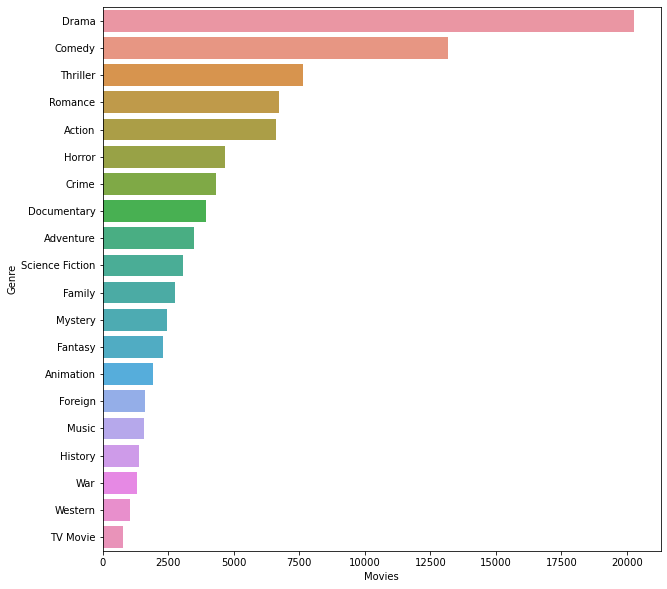

In [12]:
#barplot unique genres again
genres = []
for r in movies['genres']:
    genres.append(r)
    
allGenres = sum(genres, [])
allGenres = nltk.FreqDist(allGenres) 

genresDf = pd.DataFrame({'Genre': list(allGenres.keys()), 
                         'Movies': list(allGenres.values())})

plt.figure(figsize=(10,10)) 
sns.barplot(data=genresDf, x="Movies", y="Genre", order=genresDf.sort_values('Movies', ascending=False).Genre) 
plt.show()

The code bellow cleans the text in the movies['overview'] column by removing unnecessary characters and converting the text to lowercase which can be useful for natural language processing (NLP) tasks such as text classification or sentiment analysis.

In [23]:
#Clean data
def cleanPlot(plot):
    ps = PorterStemmer()
    sw = set(stopwords.words('english'))
    plot = re.sub("\'", "", plot) 
    plot = re.sub("[^a-zA-Z]"," ", plot)
    plot = ' '.join(plot.split()) 
    plot = plot.lower() 
    return plot

movies['overview'] = movies['overview'].apply(lambda x: cleanPlot(x))
movies.head()

,genres,movieId,overview,title
0,"[Animation, Comedy, Family]",862,led by woody andys toys live happily in his ro...,Toy Story
1,"[Adventure, Fantasy, Family]",8844,when siblings judy and peter discover an encha...,Jumanji
2,"[Romance, Comedy]",15602,a family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[Comedy, Drama, Romance]",31357,cheated on mistreated and stepped on the women...,Waiting to Exhale
4,[Comedy],11862,just when george banks has recovered from his ...,Father of the Bride Part II


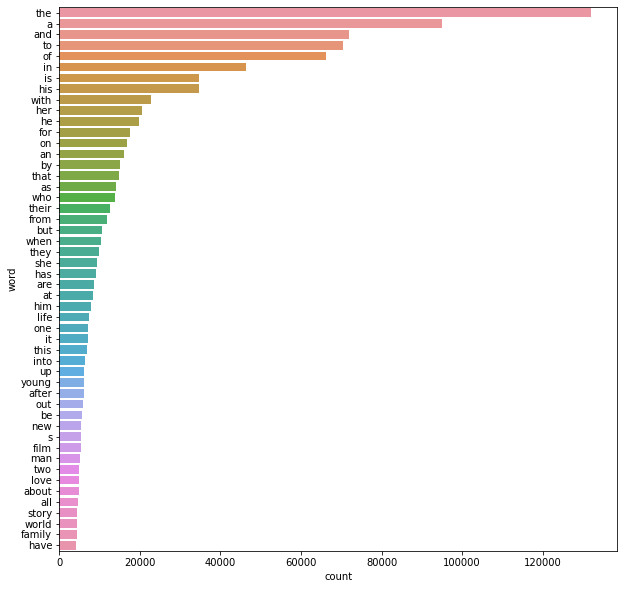

In [24]:
#visualise most frequent words
def freqWords(x, maxWords): 
  allWords = ' '.join([text for text in x]) 
  allWords = allWords.split() 
  fdist = nltk.FreqDist(allWords) 
  wordsDf = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  d = wordsDf.nlargest(columns="count", n = maxWords) 

  plt.figure(figsize=(10,10)) 
  sns.barplot(data=d, x= "count", y = "word") 
  plt.show()
  
freqWords(movies['overview'], 50)

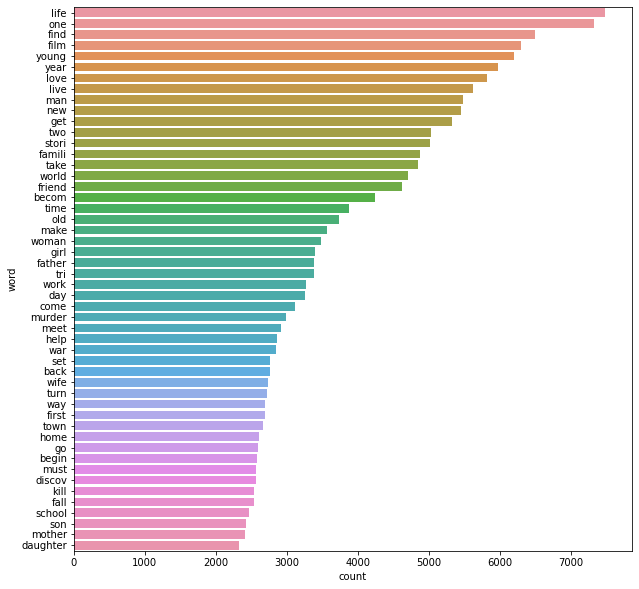

In [25]:
#Remove stopwords, apply stemming and visualise
stopWords = set(stopwords.words('english'))
ps = PorterStemmer()

def removeStopwordsAndStem(plot):
    stemmedNoStopwordPlot = [ps.stem(w) for w in plot.split() if not w in stopWords]
    return ' '.join(stemmedNoStopwordPlot)

movies['overview'] = movies['overview'].apply(lambda x: removeStopwordsAndStem(x))
freqWords(movies['overview'], 50)

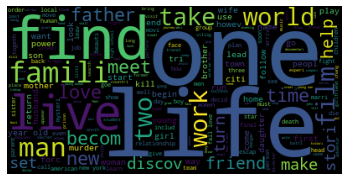

In [18]:
#word cloud visualization
corpus = []
for overview in movies['overview']:
    corpus.append(overview)

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Del za genre prediction** 

In [26]:
#Convert each genre to separate binary class
multilabelBinarizer = MultiLabelBinarizer()
multilabelBinarizer.fit(movies['genres'])

#output class
y = multilabelBinarizer.transform(movies['genres'])
y


array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

In [27]:
#Extract top 10000 most frequent words from plots
tfidfVectorizer = TfidfVectorizer(max_features=10000)

xTrain, xTest, yTrain, yTest = train_test_split(movies['overview'], y, test_size=0.2, random_state=9)

xTrainTfidf = tfidfVectorizer.fit_transform(xTrain)
xTestTfidf = tfidfVectorizer.transform(xTest)

In [28]:
#Train and test the model
lr = LogisticRegression(max_iter=10000)
clf = OneVsRestClassifier(lr)

clf.fit(xTrainTfidf, yTrain)
yPred = clf.predict(xTestTfidf)

print(yPred[2])

print(multilabelBinarizer.inverse_transform(yPred)[2])

print('F1 Score: ', f1_score(yTest, yPred, average='samples'))

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0]
('Horror', 'Science Fiction', 'Thriller')
F1 Score:  0.4421508351549025


In [29]:
#Custom tests

#Die Hard (Aventure, Crime, Thriller)
plotList = [cleanPlot("A New York City police officer tries to save his estranged wife and several others taken hostage by terrorists during a Christmas party at the Nakatomi Plaza in Los Angeles.")]
plotListTfidf = tfidfVectorizer.transform(plotList)
pred = clf.predict(plotListTfidf)
print(pred)
print(multilabelBinarizer.inverse_transform(pred))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]]
[('Thriller',)]


In [ ]:
# # Merge the two dataframes based on the ID column
# ratings['movieId'] = ratings['movieId'].astype(str)
# merged = pd.merge(movies, ratings, on='movieId', how='inner')


## Collaborative Filtering Movie Recommender System

To help with the common recommender system problem known as cold-start that is caused by lack of starting information, we will work with users that have at least 20 ratings.

In [30]:
user_ratings_count = ratings_small.groupby(['userId', 'movieId']).size().groupby('userId').size()
print('Number of users: %d' % len(user_ratings_count))
users_with_20_ratings = user_ratings_count[user_ratings_count >= 20].reset_index()[['userId']]
print('Number of users with at least 20 ratings: ', len(users_with_20_ratings))

Number of users: 39615
Number of users with at least 20 ratings:  29211


In [31]:
#drop duplicates
ratings_small = ratings_small.drop_duplicates()

We will be dropping the column timestamp.

In [32]:
ratings_small = ratings_small.drop(['timestamp'], axis=1)

................Now, we will merge the movies and ratings dataset (we will only take the movie title from the movies dataset).

In [ ]:
movies_titles = movies.drop(['overview', 'genres'], axis=1)
ratings['movieId'] = ratings['movieId'].astype(str)
merged = pd.merge(movies_titles, ratings, on='movieId', how='inner')
merged

### Splitting data to test and train sets

To ensure generalization of previously unseen data, cross-validation will be used. Data is split into two data sets - one for training (70%) and one for testing (30%). In our case of recommending movies to users, to make sure the evaluation is statisically sound, the same set of users for both model building and testing should be used (to avoid any cold-ness of users), and a stratified splitting strategy should be taken, as oppose in other cases where a chronological split would be a better fit.
We also set a minimum of 20 ratings per user so the number of rows in the dataset is likely to change. 

In [33]:
#splitting the data
ratings_train, ratings_test = python_stratified_split(
    ratings_small, filter_by="user", min_rating=20, ratio=0.7,
    col_user='userId', col_item='movieId'
)

In [36]:
#number of rows remains the same
rows_new = ratings_train.shape[0] + ratings_test.shape[0]
print('Number of rows after splitting the data and applying the filter: ' + str(rows_new))
print('Number of original rows: ' + str(ratings_small.shape[0]))

Number of rows after splitting the data and applying the filter: 1853538
Number of original rows: 2000000


In [37]:
#remove "cold" users from test set  
ratings_test = ratings_test[ratings_test.userId.isin(ratings_train.userId)]
print('Number of rows after removing cold users from test set: ' + str(rows_new))
print('Number of original rows: ' + str(ratings_small.shape[0]))

Number of rows after removing cold users from test set: 1853538
Number of original rows: 2000000


### Matrix factorization

Recommender systems use utility matrixes to store user-item data. These matrixes are characterized by their sparsity whihch poses as one of the biggest challenges in recommender systems. To handle this challenge we will be doing matrix factorization by applying Singular Value Decomposition (SVD). SVD decomposes the matrix M ($m \times n$) in the following form: $ SVD (M) = U \times S \times V^{T} $

In [40]:
#creating a sparse pivot table with users in rows and movies in columns
pivot_table = ratings_train.pivot(index='userId', columns='movieId', values='rating').fillna(0)

pivot_table

movieId,1,2,3,4,5,6,7,8,9,10,...,3265,3266,4006,4424,4970,5060,6531,6677,6918,8739
userId,,,,,,,,,,,,,,,,,,,,,
25,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270860,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270877,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
#compressed Sparse Row matrix
sparse_matrix = csr_matrix(pivot_table)
sparse_matrix

<29211x1453 sparse matrix of type '<class 'numpy.float64'>'
	with 1297155 stored elements in Compressed Sparse Row format>

In [45]:
#the number of factors to factor the utility matrix
NUMBER_OF_FACTORS = 15
#performs matrix factorization of the original utility matrix
#U, S, Vt = svds(pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, S, Vt = svds(sparse_matrix, k = NUMBER_OF_FACTORS)

In [46]:
U.shape

(29211, 15)

In [48]:
Vt.shape

(15, 1453)

In [49]:
S = np.diag(S)
S.shape

(15, 15)

After the factorization, we try to reconstruct the original utility matrix by multiplying its factors. The resulting matrix is not sparse any more.

In [50]:
all_user_predicted_ratings = np.dot(np.dot(U, S), Vt) 
all_user_predicted_ratings

array([[ 5.69106687e-02,  9.70456205e-02,  3.05937268e-01, ...,
        -4.66342071e-05, -2.91902471e-03, -4.00640456e-04],
       [ 1.92821485e+00,  7.43922108e-01, -1.48401380e-01, ...,
        -2.19164785e-04,  4.34830505e-03, -4.83729788e-04],
       [ 5.85156806e-02,  6.18996481e-01, -5.99100664e-02, ...,
         4.65570049e-05, -1.72811583e-03, -1.84496734e-03],
       ...,
       [-9.32772494e-01, -1.99274704e-01,  8.08058850e-02, ...,
        -3.80709137e-05,  3.25675748e-03,  2.01714956e-04],
       [-4.21502730e-01, -2.10424152e-01,  6.01974240e-01, ...,
        -3.97402146e-04, -5.61051387e-03, -2.56663619e-03],
       [-6.13892391e-01,  1.45406932e-01,  1.38780257e-01, ...,
        -2.84782492e-04, -5.63612394e-03, -1.92438409e-03]])

In [52]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [56]:
#converting the reconstructed matrix back to a Pandas dataframe
users_ids = list(pivot_table.index)
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = pivot_table.columns, index=users_ids).transpose()
cf_preds_df

,25,33,58,80,91,93,101,103,112,114,...,270806,270825,270829,270832,270847,270860,270877,270883,270891,270895
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.329512,0.478489,0.329640,0.375145,0.401416,0.366264,0.518202,0.357059,0.440305,0.316226,...,0.510420,0.281254,0.275548,0.387764,0.401453,0.442612,0.458504,0.250723,0.291425,0.276109
2,0.332707,0.384206,0.374260,0.373034,0.458848,0.335173,0.343932,0.392034,0.333562,0.328071,...,0.476883,0.364348,0.308913,0.422582,0.368390,0.461775,0.462229,0.309117,0.308229,0.336558
3,0.349338,0.313167,0.320212,0.319414,0.387419,0.331705,0.417520,0.317179,0.345359,0.325319,...,0.372607,0.339576,0.327089,0.326971,0.327357,0.299799,0.323024,0.331415,0.372905,0.336030
4,0.329992,0.317178,0.318794,0.321642,0.339738,0.332692,0.328048,0.316413,0.324336,0.328313,...,0.347452,0.329137,0.320449,0.330769,0.339276,0.314973,0.343105,0.328137,0.323058,0.330055
5,0.347031,0.311788,0.313940,0.322601,0.392250,0.338994,0.410179,0.314768,0.345543,0.325333,...,0.403359,0.338837,0.324285,0.354424,0.335330,0.311144,0.356327,0.328973,0.347935,0.338034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5060,0.325067,0.318398,0.321830,0.325430,0.317153,0.326031,0.319177,0.327828,0.325740,0.328311,...,0.326360,0.326986,0.323912,0.331939,0.320715,0.326326,0.323582,0.329656,0.323279,0.327051
6531,0.324893,0.325047,0.324909,0.324829,0.324588,0.325014,0.324796,0.324795,0.325105,0.325145,...,0.324695,0.324881,0.324854,0.324943,0.324964,0.324656,0.325133,0.324911,0.324669,0.324875
6677,0.324978,0.324964,0.324985,0.324970,0.324958,0.324986,0.324988,0.324941,0.324999,0.325002,...,0.324969,0.324978,0.324981,0.324988,0.324946,0.324921,0.325001,0.324979,0.324950,0.324959


...............................................

In [ ]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions, items=None):
        self.cf_predictions = cf_predictions
        self.items = items
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)